In [1]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
import geopandas
import glob
import os
from pyorbital import astronomy
from datetime import datetime, timedelta
from shapely import geometry

## Data Preparation

In [3]:
def compute_sun_glint_angle(sat_angle):
    """Compute the sun glint angle. Sun glint angle is defined as the angle difference between reflected solar beam and
    the satellite view/zenith angle, from the satellite reference frame. If the angle is small, it means that the
    reflected solar beam is seen by the satellite as sun glint.

    The eqn of sun glint is
        cos (theta_g) = cos (theta_v) * cos (theta_s) - sin (theta_v) * sin (theta_s) * cos (phi), where
        theta_g = sun glint angle, theta_v = satellite view/zenith angle, theta_s = solar zenith angle,
        phi = relative azimuth angle (difference between solar and satellite azimuth angle)

    For more info, refer to "An Enhanced Contextual Fire Detection Algorithm for MODIS" by Louis Giglio et al 2003
    https://doi.org/10.1016/S0034-4257(03)00184-6

    Args:
        sat_angle (dict): Dict of satellite angles: {
                        'viewzenang' (float): satellite view/zenith angle,
                        'solarzenang' (float): solar zenith angle,
                        'relazang' (float): relative azimuth angle ,
                         }

    Returns:
        sun_glint_angle (float): Angle of sun glint in degrees

    """
    theta_v = np.radians(sat_angle['viewzenang'])
    theta_s = np.radians(sat_angle['solarzenang'])
    phi = np.radians(sat_angle['relazang'])
    cos_sunglint = np.cos(theta_v) * np.cos(theta_s) - (np.sin(theta_v) * np.sin(theta_s) * np.cos(phi))
    sun_glint_rad = np.arccos(cos_sunglint)
    sun_glint_angle = np.degrees(sun_glint_rad)

    return sun_glint_angle

In [4]:
def parse_jaxa_hotspot_txt(file_path):
    """
    Parse the JAXA Himawari-8/9 AHI hotspot text file and insert attrs into the Pandas DataFrame

    Args:
        file_path (str): File path to the JAXA Himawari-8/9 hotspot .csv
          
    Returns:
        hs_df (obj): DataFrame obj that contains attr of Himawari-8/9 hospot
        
    """
    hs_ahi_df = pd.DataFrame()
    cols_to_use_list = [0, 2, *(i for i in range(7,27))]
    date_col_list = [0]
    names_list = ['date', 'satellite', 'lon', 'lat', 'viewzenang', 'viewazang', 'pixwid', 'pixlen', 't07',   
                  't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 
                  'ref3', 'ref4', 'fire_idx', 'fire', 'test1_6']
        

    for file in glob.glob(file_path):
            
        try:
            print (f'Reading {file}')
            temp_hs_ahi_df = pd.read_csv(file, sep=",", skiprows=[0], \
                                         header=None, usecols=cols_to_use_list, \
                                         names=names_list, \
                                         parse_dates=date_col_list)
            temp_hs_ahi_df['satellite'] = 'Himawari-8/9'
        except Exception as e:
            print (f'Error reading {file}')
            print (e)
            continue

        if len(temp_hs_ahi_df) > 0:
                   
            try:
                temp_hs_ahi_df['solarazang'] = temp_hs_ahi_df.apply( \
                    lambda x: np.degrees(astronomy.get_alt_az(x['date'], x['lon'], x['lat'])[1]), axis=1)
                temp_hs_ahi_df['solarzenang'] = temp_hs_ahi_df.apply( \
                    lambda x: astronomy.sun_zenith_angle(x['date'], x['lon'], x['lat']), axis=1)
                temp_hs_ahi_df['relazang'] = temp_hs_ahi_df['solarazang'] - temp_hs_ahi_df['viewazang']
                temp_hs_ahi_df['sunglint_angle'] = temp_hs_ahi_df.apply(compute_sun_glint_angle, axis=1)
            except Exception as e:
                temp_hs_ahi_df['sunglint_angle'] = np.nan
                
            try:
                temp_hs_ahi_df.loc[(temp_hs_ahi_df['date'].dt.hour >= 0) \
                                   & (temp_hs_ahi_df['date'].dt.hour <= 11), 'daynight'] = 'day'
                temp_hs_ahi_df.loc[temp_hs_ahi_df['date'].dt.hour > 11, \
                                   'daynight'] = 'night'
                temp_hs_ahi_df['date'] = temp_hs_ahi_df['date'].dt.strftime( \
                    "%d/%m/%Y %H:%M:%S")
            except Exception as e:
                date_from_file = datetime.strptime(filename[4:17], "%Y%m%d_%H%M")
                temp_hs_ahi_df['date'] = date_from_file.strftime("%d/%m/%Y %H:%M:%S")

        hs_ahi_df = pd.concat([hs_ahi_df, temp_hs_ahi_df])

    if len(hs_ahi_df) > 0:
        hs_ahi_df = hs_ahi_df.reset_index(drop=True)

    return hs_ahi_df

In [ ]:
hs_df_apr = parse_jaxa_hotspot_txt(file_path="../../data/raw/hotspots/ahi/H08_20190[4]*_0[2-7]*_L2WLFbet_FLDK*.csv")

In [ ]:
hs_df_sep = parse_jaxa_hotspot_txt(file_path="../../data/raw/hotspots/ahi/H08_20190[9]*_0[2-7]*_L2WLFbet_FLDK*.csv")

In [ ]:
hs_df =  pd.concat([hs_df_apr, hs_df_sep])

In [4]:
hs_df = pd.read_csv("../../data/raw/hotspots/pd_df_ahi_apr_sep_2019.csv")

In [5]:
hs_df['date'] = pd.to_datetime(hs_df['date'], format='%d/%m/%Y %H:%M:%S')

The ground truth data is collected based on satellite imageries from TERRA, Sentinel-2, NPP, AQUA, NOAA-20 imageries. We make the following assumptions:

* Fire persists non-stop from 0230 to 0730 UTC

Thus, we only look at fire hotspot data in between this period for validation and training.

In [6]:
from datetime import time, datetime
start_time = time(2, 30, 0)
end_time = time(7, 30, 0)
time_filter = (hs_df['date'].dt.time >= start_time) & (hs_df['date'].dt.time <= end_time)
hs_df_short = hs_df[time_filter]

In [7]:
hs_df_short.reset_index(inplace=True, drop=True)

In [8]:
#convert to GeoDataFrame
hs_gdf = geopandas.GeoDataFrame(hs_df_short, geometry=geopandas.points_from_xy(hs_df_short.lon, hs_df_short.lat))

In [9]:
#Change to Mercator (metres) projection as we need to adjust the buffer in metres
hs_gdf.crs = {'init': 'epsg:4326'}
hs_gdf = hs_gdf.to_crs({'init': 'epsg:3857'})

`overlay` only works when for polygon-polygon and not for point-polygon pair. Thus we need to convert the hotspot point coordinate to a polygon.

In [10]:
#convert point to polygon
hs_gdf.geometry = hs_gdf.buffer(1)

In [11]:
truth_df = pd.read_csv('../../references/ground_truth/processed/daily_ground_truth_Apr_Sep_2019.csv')

In [12]:
truth_df.head()

,Unnamed: 0,datestamp,geometry,lat,lon,end_date,start_date,period
0,0,2019/09/01,POINT (11371379.4241247 47734.60307035755),0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000
1,1,2019/09/01,POINT (11371513.1889242 47386.80492229513),0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000
2,2,2019/09/01,POINT (11399898.0793779 -14065.19130801257),-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000
3,3,2019/09/01,POINT (11399068.73762101 -13984.93223427522),-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000
4,4,2019/09/01,POINT (11400433.1385759 -14038.43828318712),-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000


In [13]:
truth_df.drop(columns=["Unnamed: 0"], inplace=True)
#convert ground truth data to Geo DataFrame
truth_gdf = geopandas.GeoDataFrame(truth_df, geometry=geopandas.points_from_xy(truth_df.lon, truth_df.lat))

In [14]:
truth_gdf.crs = {'init' :'epsg:4326'}
truth_gdf = truth_gdf.to_crs({'init': 'epsg:3857'})

The native resolution of AHI fire hotspot is 2km. We assume that buffer of 1 km is acceptable for verification.

In [15]:
truth_gdf_buffered = truth_gdf.buffer(1000)

In [16]:
truth_gdf.geometry = truth_gdf_buffered

In [17]:
#area of interest
clip_area = geopandas.read_file('../../references/ground_truth/shapefile/aoi.shp')
clip_area = clip_area.to_crs({'init': 'epsg:3857'})
clip_area.crs

{'init': 'epsg:3857'}

In [18]:
#clip and remove hotspots outside of aoi
hs_df_clipped = geopandas.overlay(clip_area, hs_gdf, how='intersection')

In [19]:
hs_df_clipped.to_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped.geojson', driver='GeoJSON')

## Data Preparation: Merging Ground Truth Data with Hotspot Data

In [20]:
hs_df_clipped = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped.geojson', driver='GeoJSON')
truth_gdf['id_truth'] = truth_gdf.index

In [21]:
#overlay both groundtruth and AHI hotspot data
combined_gdf = geopandas.overlay(truth_gdf, hs_df_clipped, how='union')
combined_gdf.head()

,datestamp,lat_1,lon_1,end_date,start_date,period,id_truth,id,Unnamed: 0,date,...,solarazang,solarzenang,sunglint_angle,t07,t07_t14,t14,test1_6,viewazang,viewzenang,geometry
0,2019/09/01,-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
1,2019/09/06,-0.124484,102.395798,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1075.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
2,2019/09/06,-0.127922,102.401987,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1076.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
3,2019/09/08,-0.115421,102.405331,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1326.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
4,2019/09/17,-0.111719,102.397897,2019-09-17,2019-09-17,0 days 00:00:00.000000000,6622.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."


In [22]:
combined_gdf.drop(columns='id', inplace=True)

In [23]:
combined_gdf.rename(columns={'lat_1': 'lat_gt', 'lon_1': 'lon_gt', 'lat_2': 'lat', 'lon_2': 'lon', 'Unnamed: 0': 'id_hs'}, inplace=True)

In [24]:
combined_gdf.to_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped_gtruth_union.geojson', driver='GeoJSON')

## Data Preparation: Cleaning Combined Data

In [3]:
#read in dataframe consists of uncleaned ground truth and raw AHI hotspot detection
combined_gdf = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped_gtruth_union.geojson')

In [7]:
#check if ground truth date is valid
combined_gdf['datestamp'].unique()

array(['2019-09-01', '2019-09-06', '2019-09-08', '2019-09-17',
       '2019-09-03', '2019-09-07', '2019-09-20', '2019-09-04',
       '2019-09-05', '2019-09-02', '2019-09-10', '2019-09-12',
       '2019-09-26', '2019-09-11', '2019-09-14', '2019-09-22',
       '2019-09-30', '2019-09-19', '2019-09-16', '2019-09-13',
       '2019-09-18', '2019-09-29', '2019-09-24', '2019-09-21',
       '2019-09-23', '2019-09-09', '2019-09-28', '2019-09-15',
       '2019-09-25', '2019-09-27', '2019-04-01', '2019-04-14',
       '2019-04-18', '2019-04-04', '2019-04-05', '2019-04-06',
       '2019-04-08', '2019-04-24', '2019-04-11', '2019-04-17',
       '2019-04-12', '2019-04-20', '2019-04-13', '2019-04-09',
       '2019-04-02', '2019-04-15', '2019-04-03', '2019-04-19',
       '2019-04-23', '2019-04-22', '2019-04-26', '2019-04-10',
       '2019-04-21', '2019-04-07', '2019-04-16', '2019-04-29',
       '2019-04-30', '2019-04-25', '2019-04-28', '2019-04-27', None],
      dtype=object)

In [8]:
combined_gdf['date'] = pd.to_datetime(combined_gdf['date'])

In [9]:
#initialize with nan
combined_gdf['truth_flag'] = np.nan

In [179]:
#remove data points if date of detected hs is not the same as date of ground truth data
filter_valid_union = combined_gdf['date'].notna() & combined_gdf['datestamp'].notna()
filter_same_date = combined_gdf['date'].dt.strftime('%Y-%m-%d') == combined_gdf['datestamp']
combined_gdf_clean = combined_gdf.drop(combined_gdf[filter_valid_union & (~filter_same_date)].index, axis=0)

In [180]:
#set flag of label coinciding hotspots with same date to 1
combined_gdf_clean.loc[combined_gdf_clean['date'].dt.strftime('%Y-%m-%d') == combined_gdf_clean['datestamp'], 'truth_flag'] = 1
#Set to -1 for missed detections
combined_gdf_clean.loc[combined_gdf_clean['id_hs'].isna(), 'truth_flag'] = -1

In [181]:
#Set to 0 for false alarm
combined_gdf_clean.loc[combined_gdf_clean['id_truth'].isna(), 'truth_flag'] = 0

In [187]:
#get hits and false alarm, avoid double counting of hits (only count as one hit even if hs coincides with multiple ground truth)
combined_gdf_clean_hits_falsealarms = combined_gdf_clean.drop_duplicates(subset=['id_hs'], keep='first')

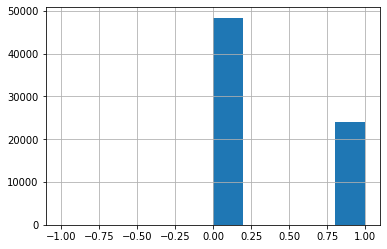

In [188]:
combined_gdf_clean_hits_falsealarms['truth_flag'].hist()

In [189]:
#If a ground truth data has been identified as a hit, it shouldn't be considered as a missed detection anymore. 
#special handling due to union operation, get the list of ground truth data which has been identified as a hit
hits_id_truth_list = combined_gdf_clean_hits_falsealarms.loc[combined_gdf_clean_hits_falsealarms['truth_flag'] == 1, 'id_truth'].unique()

In [190]:
#get missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean[combined_gdf_clean['id_hs'].isna()].copy()
#remove redundant ground truth data misidentified as missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean_missed_detections[~combined_gdf_clean_missed_detections['id_truth'].isin(hits_id_truth_list)].copy()

In [191]:
combined_gdf_clean_dup_removed = pd.concat([combined_gdf_clean_hits_falsealarms, combined_gdf_clean_missed_detections]).drop_duplicates()

In [192]:
#check if double count missed detection or not
try:
    assert combined_gdf_clean_dup_removed[combined_gdf_clean_dup_removed['id_hs'].isna()].duplicated(subset=['id_truth'], keep=False).sum() == 0.0
    print ('Data is clean. No double counting of missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No double counting of missed detections.


In [200]:
#check if there are no misclassified missed detections
try:
    assert combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['id_truth'].isin(hits_id_truth_list), 'id_hs'].isna().sum() == 0.0
    print ('Data is clean. No misclassified missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No misclassified missed detections.


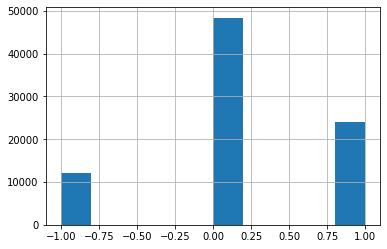

In [201]:
combined_gdf_clean_dup_removed['truth_flag'].hist()

In [203]:
combined_gdf_clean_dup_removed.to_file('../../data/interim/h8_ml_apr_sep_2019_clean.geojson', driver='GeoJSON')

## Model Training

In [2]:
ml_gdf = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_clean.geojson')

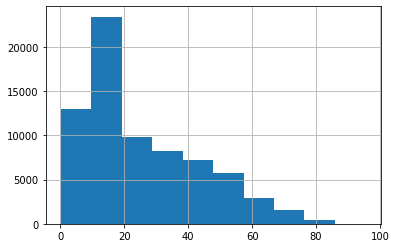

In [3]:
ml_gdf['sunglint_angle'].hist()

In [4]:
ml_gdf.loc[ml_gdf['truth_flag'] == -1, 'truth_flag'] = 1

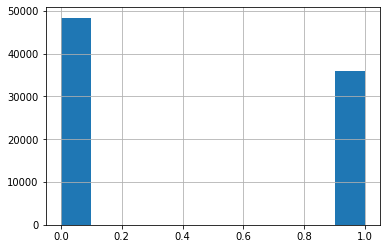

In [5]:
%matplotlib inline
_ = ml_gdf['truth_flag'].hist()

In [6]:
predict_gdf = ml_gdf.copy()

In [7]:
predict_gdf = predict_gdf.reset_index(drop=True)

## Sun-glint filter as a baseline model

Here we create a baseline model using sunglint filter. If sunglint angle is small (e.g ~ 0), the probability of the hotspot being a real hotspot should be low.

In [8]:
MAX_SG_ANGLE = 90.0
predict_gdf['sg_model_prob'] = np.clip(predict_gdf['sunglint_angle']/ MAX_SG_ANGLE, a_min=0, a_max=1.0)
predict_gdf.loc[predict_gdf['id_hs'].isna(), 'sg_model_prob'] = 0

The focus of the ML model is to improve existing JAXA Hotspot product - specifically on reducing false alarm rate while maintaining same level of performance. We make the following assumptions:

* From operational experience, the JAXA hotspot product appears to be able to pick up most fires, but at a cost of very high false alarm rate.
* We assume that if the baseline AHI hotspot product is unable to detect the **Missed Detections**, then we assume that the fire inherently could not be detected by the JAXA contextual algorithm.
* Small fires which cannot be detected by the AHI sensor are not of interest to operational users.

Stage 1:
Therefore, we will first train a model and assess its performance using dataset that excludes **Missed Detections** that were not picked up by the JAXA hotspot product.

Stage 2:
Performance of the trained model will be reasssesed later using dataset that included missed detections.

In [12]:
#For Stage 1
predict_features = ['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'sunglint_angle']
predict_gdf_no_FN = predict_gdf.dropna(subset=predict_features)

## Feature Selection 

In [13]:
corr_features = [*predict_features, 'truth_flag']

### Correlation Matrix

(13.5, -0.5)

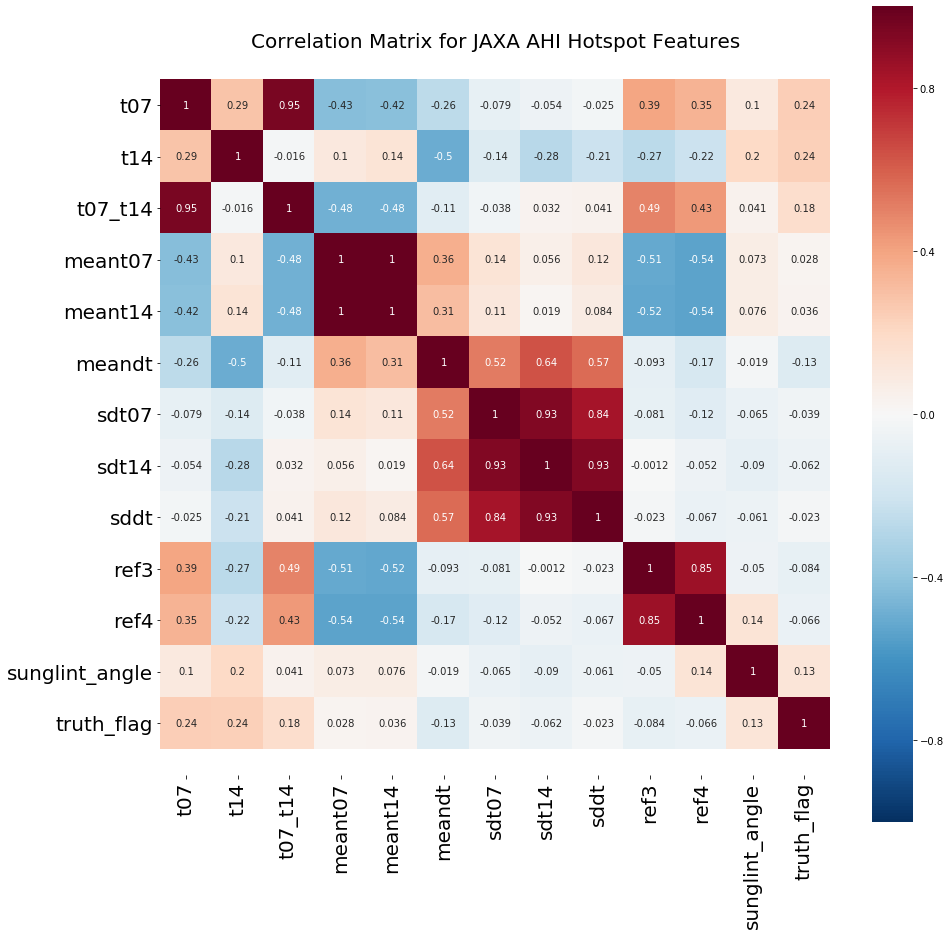

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrx = predict_gdf_no_FN[corr_features].corr()
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax = sns.heatmap(corr_matrx, vmin=-1.0, vmax=1.0, annot=True, square=True, cmap='RdBu_r',annot_kws={"size": 10})
ax.tick_params(labelsize=20)
plt.yticks(rotation='horizontal')
ax.set_title('Correlation Matrix for JAXA AHI Hotspot Features', {'fontsize':20})


b, t = plt.ylim() # discover the values for bottom and top
b += 1 # Add 0.5 to the bottom
t -= 1 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

Looking at the correlation matrix heatmap, we can roughly group the features into 4 clusters:
    
1. `t07`, `t14`, `t07_t14` - absolute brightness temperatures of SWIR and IR channels
2. `meant07`, `meant14`, `meandt` - mean of brightness temperatures of SWIR and IR channels for neighbouring pixels
3. `sdt07`, `sdt14`, `sddt` - standard deviations of brightness temperatures of SWIR and IR channels for neighbouring pixels
4. `ref3`, `ref4`, `sunglint_angle` - solar reflectivity channels associated with visible and NIR channels, as well as sun glint reflections

The above is consistent with the contextual algorithm developed for fire detection. It is reasonably to use these features but we will explore using dimension reductionality technique to see if we can further improve the prediction.

We also examine the relative importance and relationship of the features with the ground truth label `truth_flag`. 

In [15]:
predict_gdf_no_FN[corr_features].corr()['truth_flag'].sort_values()

meandt           -0.132836
ref3             -0.083910
ref4             -0.066161
sdt14            -0.061951
sdt07            -0.039473
sddt             -0.023150
meant07           0.027913
meant14           0.036420
sunglint_angle    0.129207
t07_t14           0.178357
t14               0.238801
t07               0.243234
truth_flag        1.000000
Name: truth_flag, dtype: float64

The following features have negative correlations
* `ref3` `ref4`

In a way, it makes sense as presence of solar channels contaminates the SWIR channels and contributes to false alarms. 

The following features have relatively low importance, which was slightly surprising. These are part of the contextual algorithm which compares values of neighbouring pixels with center pixel.
* `std14`, `sdt07`, `sddt`, `meant07`, `meant14`

The following features have relatively high importance.
* `meandt` has a relatively high importance. It's not clear why it has a negative correlation. Perhaps due to the presence of false alarms data.
* `t07_t14`. This is one of the key parameters used to calculate temperature difference, and is known to be a good predictor for fire activity.
* `t07`, `t14`. Higher brightness temperatures typically indicate presence of fire activity.
* `sunglint_angle`. Sunglint is the main reason behind false alarm. Small sunglint angle means there's strong reflection from the sun glint off the surface into the satellite sensor.


We will need to examine the coefficients later after running through a Linear Logistic Regression model.



### Violin Plot
We make violin plots to visualise the features and label.

It's apparently quite difficult to draw conclusion based on visual inspection.

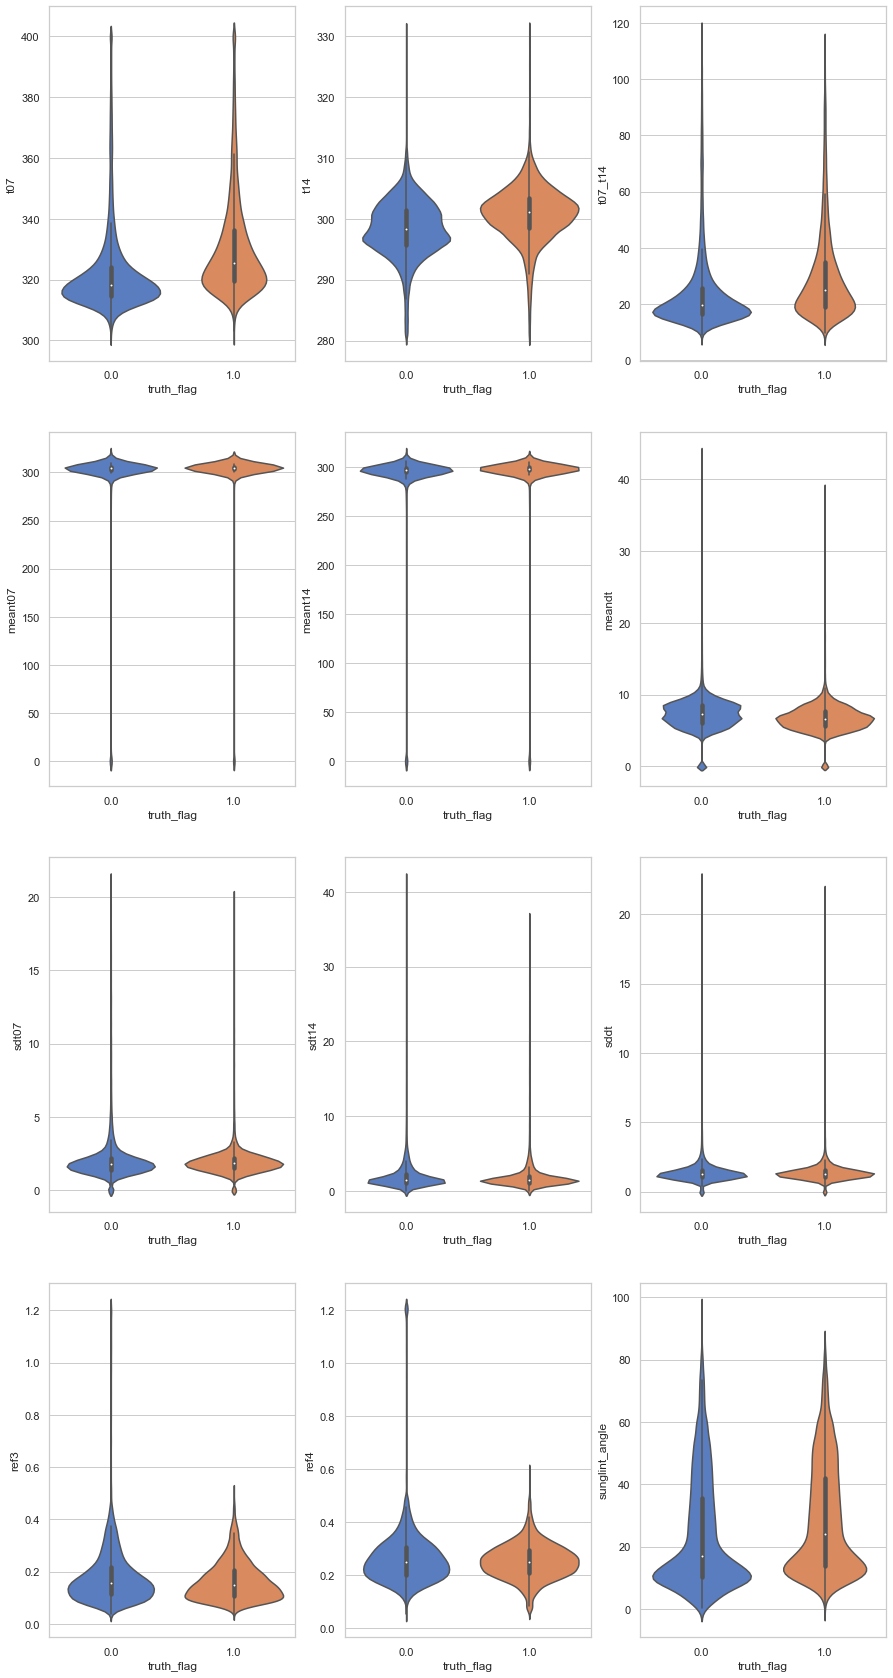

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = 4, 3
for index, feature in enumerate(predict_features):
    ax = fig.add_subplot(nrow,ncol,index + 1)
    _ = sns.violinplot(x=predict_gdf_no_FN['truth_flag'], y=predict_gdf_no_FN[feature], palette="muted", cut=2)
    axes.append(ax)

### Dimension Reduction

These features were deliberately prepared with our domain knowledge. For exploration purpose, I'll use **Principal Component Analysis** to reduce the number of features. First, we will apply Standard Scaling to transform the data.

In [17]:
from sklearn.preprocessing import StandardScaler
std_scale_features = []
predict_gdf_no_FN_scaled = predict_gdf_no_FN[[*predict_features, 'truth_flag']]
std_scaler = StandardScaler()
predict_gdf_no_FN_scaled[predict_features] = std_scaler.fit_transform(predict_gdf_no_FN_scaled[predict_features])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


After applying standard scaling, the values of the features are transformed.

In [18]:
predict_gdf_no_FN_scaled.head()

,t07,t14,t07_t14,meant07,meant14,meandt,sdt07,sdt14,sddt,ref3,ref4,sunglint_angle,truth_flag
0,-0.320900,-0.199377,-0.271902,0.105830,0.050314,0.962916,-0.906657,-0.618319,-0.645863,-0.388013,-0.405163,1.584343,1.0
1,-0.445611,-0.254245,-0.384725,0.117143,0.094806,0.412317,-0.526245,-0.503685,-0.410861,-0.792932,-0.340422,0.677850,1.0
2,-0.206422,-0.271127,-0.129704,0.100541,0.055857,0.780124,-0.756031,-0.661996,-0.612908,-0.433004,-0.340422,1.859881,1.0
3,1.473661,-0.271127,1.624071,0.100607,0.045454,0.955118,-0.923265,-0.581367,-0.436345,0.016907,-0.146201,0.231319,1.0
4,1.219122,-0.055878,1.290273,0.087645,0.059836,0.493911,-0.719820,-0.586543,-0.303280,-0.531984,-0.932336,-0.796583,1.0


In [19]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(predict_gdf_no_FN_scaled[predict_features])
pca.explained_variance_ratio_

array([3.40197767e-01, 2.65615582e-01, 1.26907232e-01, 9.17099014e-02,
       7.43952048e-02, 5.50257293e-02, 2.12041015e-02, 1.30831497e-02,
       9.73805908e-03, 2.12327325e-03, 6.78503020e-14, 1.85254338e-31])

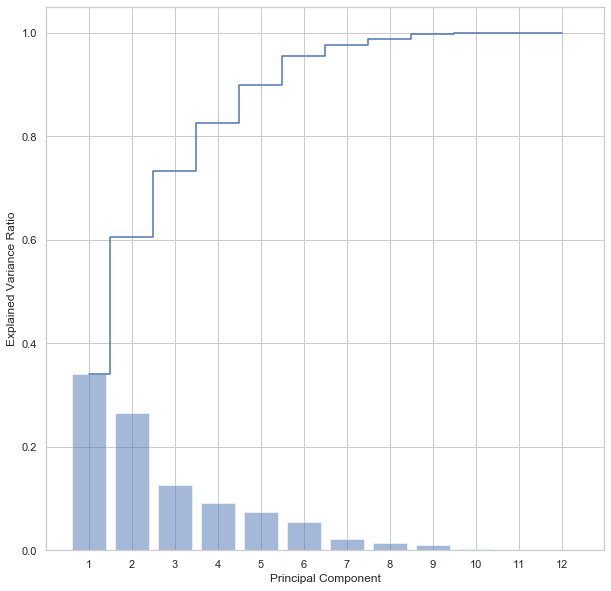

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
_ = ax.bar(range(1, len(predict_features) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
_ = plt.step(range(1, len(predict_features) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance Ratio')
_ = ax.xaxis.set_ticks(np.arange(1, len(predict_features) + 1, 1))

We see that about the first 9/12 components can explain about 99% of the explained variance. Now we plot the violin plot again.

In [21]:
pca_nmax = 9

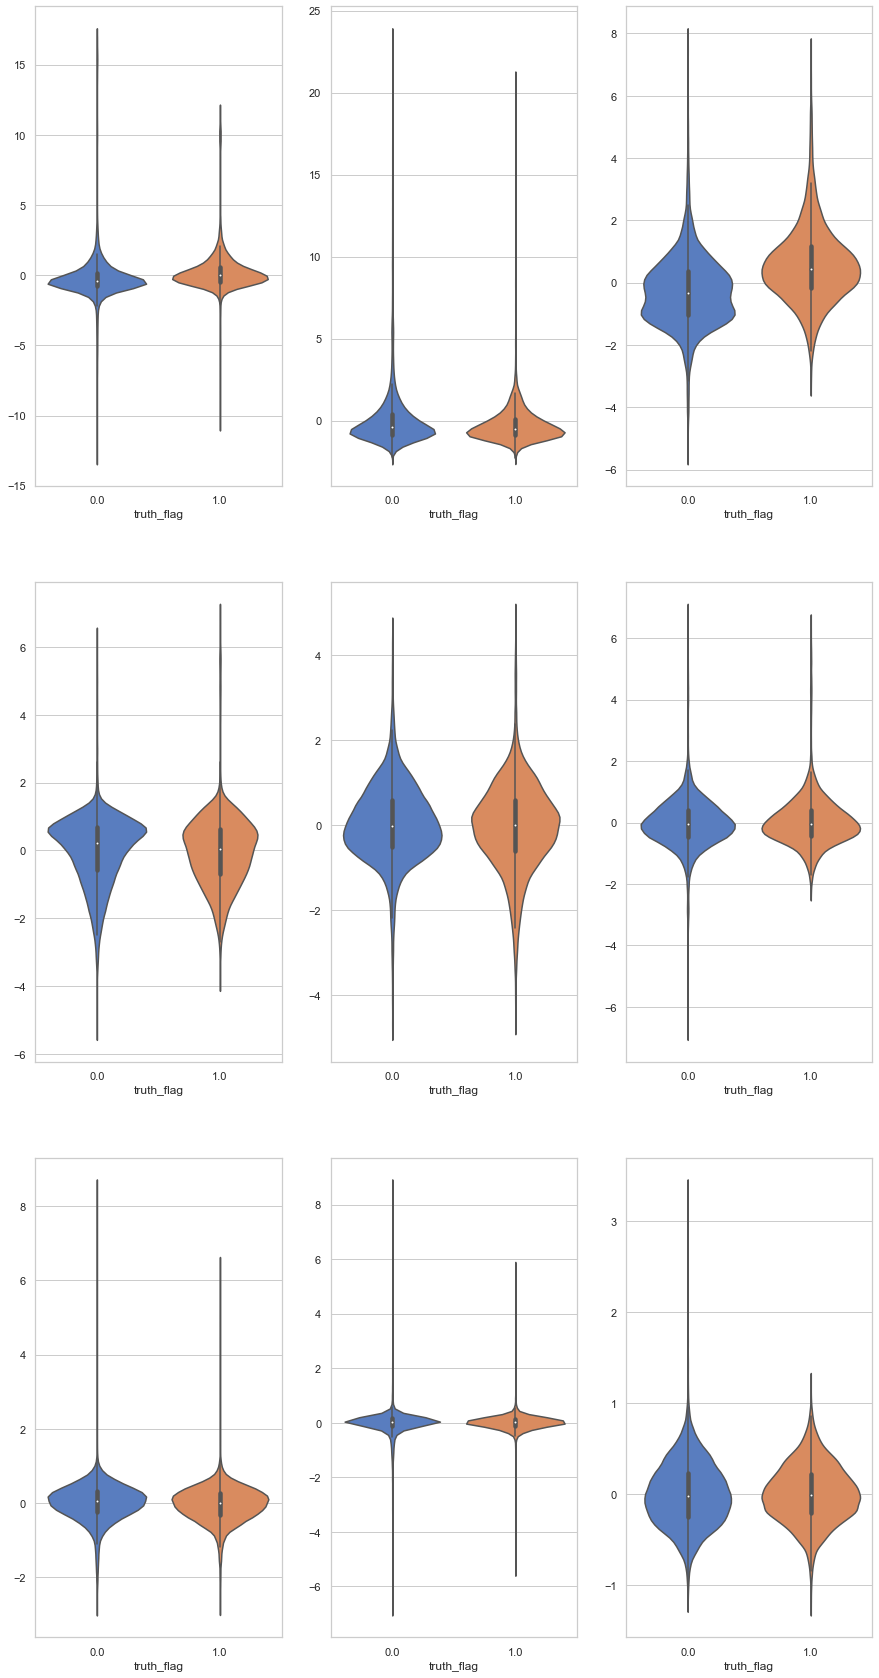

In [22]:
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = pca_nmax/3, 3
for i in range(0, pca_nmax, 1):
    ax = fig.add_subplot(nrow,ncol, i + 1)
    _ = sns.violinplot(x=predict_gdf_no_FN_scaled['truth_flag'], y=X_train_pca[:,i], palette="muted", cut=2)
    axes.append(ax)

However, we still don't see a very clear pattern visually. We'll now examine each principal component and check the relative contribution of the original features.

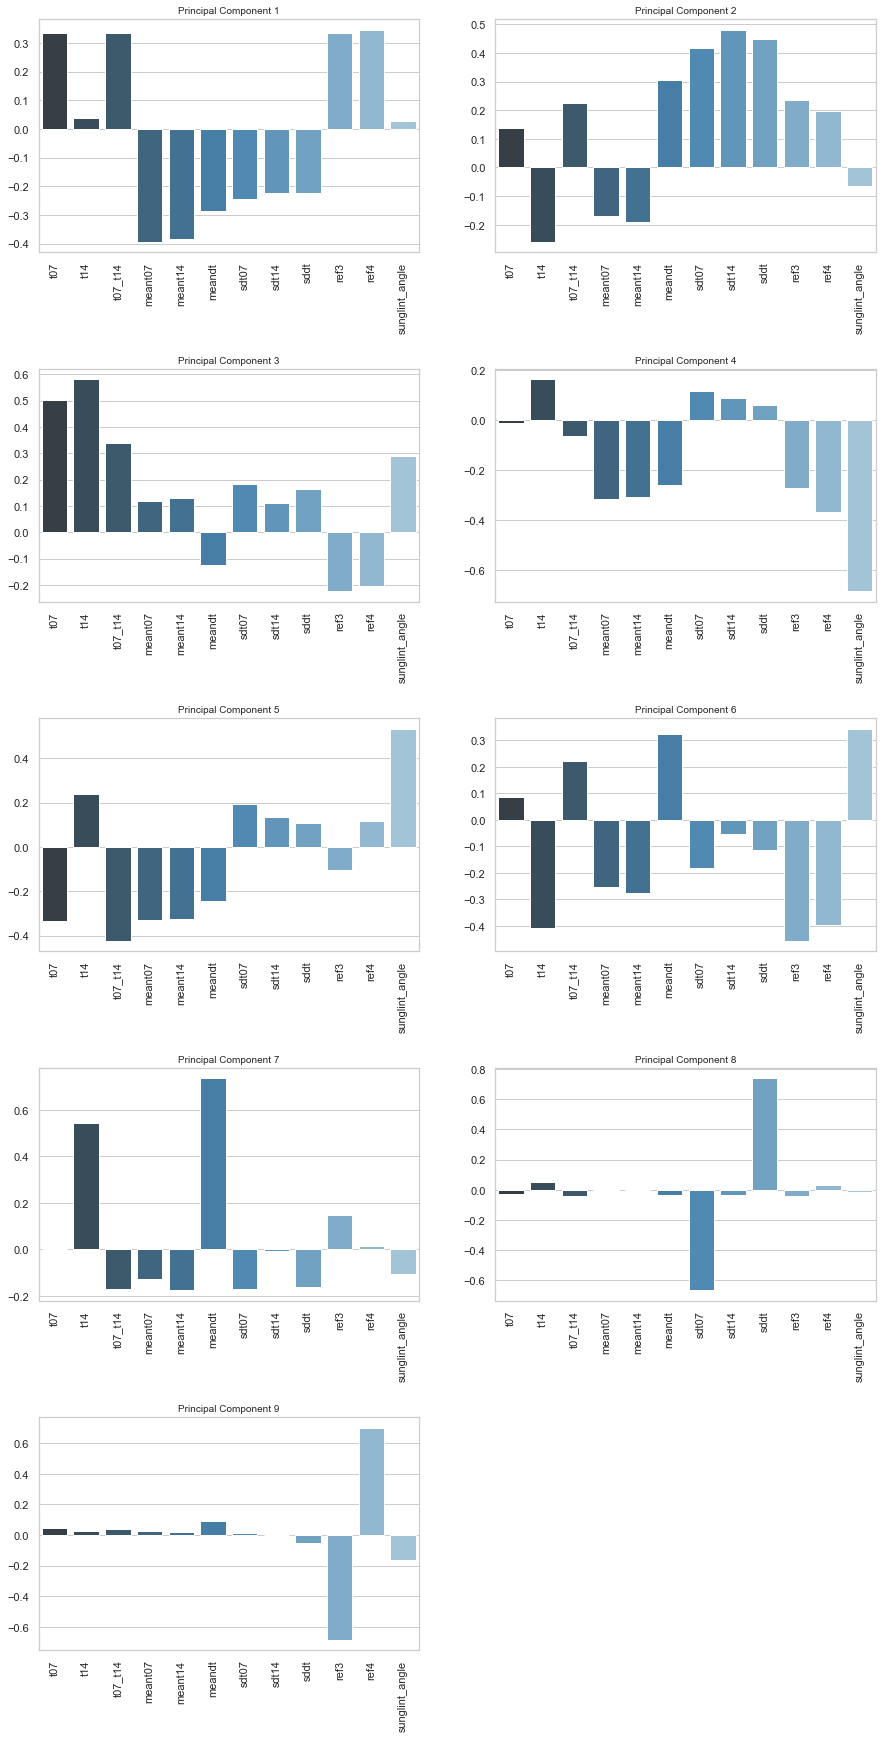

In [23]:
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = int(pca_nmax/2) + 1, 2
for i in range(0, pca_nmax, 1):
    ax = fig.add_subplot(nrow,ncol, i + 1)
    ax = sns.barplot(y=pca.components_[i], x=predict_features, palette="Blues_d")
    _ = plt.xticks(rotation='vertical')
    ax.set_title(f'Principal Component {i+1}', {'fontsize':10})
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)  
    axes.append(ax)

### Understanding the Principal Components

We'll try to make a sense of what the principal components represent, physically. We look at the top 3 PCs.

| Principal Component   |      Description      | 
|----------|:-------------:|
| PC 1 |  Highly reflective sun glint induced hotspots. |
| PC 2 |  Difficult to draw conclusion. Possibly hotspots near water bodies.  | 
| PC 3 |  High temperature hotspots with cooler neighbouring pixels. Typically indicates a real fire activity. This is shown on the violin plot by the bigger separation between the two labelled classes. |
    

## Model Selection

We choose a list of baseline classifiers, with the following choices of hyperparameters for grid search. We'll pass these classifiers through **k-fold** cross validation. After the **k-fold** cross-validation is done, we will assess and pick the best baseline algorithm. Therefore, we will do one more training using the complete training set with the chosen classifier.

The choices of baseline classifiers are:
* Logistic Classifier
* Random Forest Classifier
* Support Vector Machine Classifier
* Gradient Boosting Classifier
* Linear Discriminant Analysis
* Neural Network

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [25]:
#Setup the grid search params
model_param_json = {
    'LR': {
        'clf': LogisticRegression(fit_intercept=True, penalty='l1', solver='liblinear'),
        'param_grid': [
            { 'clf__C': [0.5, 1.0, 2, 5],
             'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']},
        ]
    },
    'SVM': {
        'clf': SVC(kernel='rbf', gamma='auto', probability=True),
        'param_grid': [
            { 'clf__C':[0.5, 1, 2, 10, 100],
             'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
        ]
    },
    'RF': {
        'clf': RandomForestClassifier(max_depth=5, random_state=123, n_jobs=-1),
        'param_grid': [
            { 'clf__n_estimators':[100, 1000],
             'clf__max_depth': [3, 5, 10],
             'clf__min_samples_split': [2, 10, 25],
            'clf__min_samples_leaf': [1, 5, 10]},
        ]
    }   
}

## Model Training & Cross-Validation
Note that the distribution of the **True/False** fire labels is not equal and thus we will need to balance the labels for training.
We first use  `StratifiedKFold` to split up into **training** and **test** datasets **k-fold** while keeping the ratio of True/False fire labels. This helps us to assess the performance of model in real-life. For each of the **training** dataset, we use resampling without replacement to downsample the majority class - **False** fire label so that the ratio of the two class labels is equal.

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for train_index, test_index in skf.split(predict_gdf_no_FN[predict_features], predict_gdf_no_FN['truth_flag']):
    
    training_df = predict_gdf_no_FN.iloc[train_index].copy()
    test_df = predict_gdf_no_FN.iloc[test_index].copy()
            
    training_minority_df = training_df[(training_df['truth_flag'] == 1)]
    training_majority_df = training_df[(training_df['truth_flag'] == 0)]
    
    training_downsampled_df = resample(training_majority_df, replace=False, 
                                       n_samples=len(training_minority_df), random_state=123)
    
    training_balanced_df = pd.concat([training_downsampled_df, training_minority_df])
    
    for model in model_param_json.keys():
        print (f'We are now training {model}')
        clf_pipeline = Pipeline([('std', StandardScaler()), ('clf', model_param_json[model]['clf'])])
        gs_clf = GridSearchCV(estimator=clf_pipeline, 
                               param_grid=model_param_json[model]['param_grid'], 
                               scoring='roc_auc', 
                               n_jobs=-1, 
                               cv=5, 
                               verbose=1, 
                               refit=True,
                               pre_dispatch='2*n_jobs')
        gs_clf.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
        
        print (f'Best estimator : {gs_clf.best_estimator_}')
        print (f'Best score : {gs_clf.best_score_}')
        print (f'Best params : {gs_clf.best_params_}')

We are now training LR


C:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best score : 0.7172801319574005
Best params : {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
We are now training SVM


In [321]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for train_index, test_index in skf.split(predict_gdf_no_FN_scaled[predict_features], predict_gdf_no_FN_scaled['truth_flag']):
    training_df = predict_gdf.iloc[train_index].copy()
    training_df_na_filter= training_df['id_hs'].isna()
    training_df.loc[training_df_na_filter, 'logit_prob'] = 0
    
    print (training_df_na_filter.sum())
    
    test_df = predict_gdf.iloc[test_index].copy()
    test_df_na_filter = test_df['id_hs'].isna()
    test_df.loc[test_df_na_filter, 'logit_prob'] = 0
    
    print (test_df_na_filter.sum())
        
    training_minority_df = training_df[(training_df['truth_flag'] == 1)]
    training_minority_df.dropna(subset=predict_features, inplace=True)
    training_majority_df = training_df[(training_df['truth_flag'] == 0)]
    training_majority_df.dropna(subset=predict_features, inplace=True)
    
    training_downsampled_df = resample(training_majority_df, replace=False, n_samples=len(training_minority_df), random_state=123)
    
    training_balanced_df = pd.concat([training_downsampled_df, training_minority_df])
            
    clf = LogisticRegression(fit_intercept=True, penalty='l1', solver='liblinear')
    #clf = RandomForestClassifier(max_depth=5, random_state=123)
    #clf = RandomForestClassifier(max_depth=5, random_state=123, class_weight = 'balanced')
    #clf = SVC(probability=True, gamma='auto', kernel='sigmoid')
    clf.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])

    
    #for coeff, feature in zip(logit_model.coef_[0], predict_features):
    #    print (coeff, feature)
    
    y_proba = clf.predict_proba(training_balanced_df[predict_features])[:, 1]
    test_df.loc[~test_df_na_filter, 'logit_prob'] = clf.predict_proba(test_df.loc[~test_df_na_filter, predict_features])[:, 1]
    training_df.loc[~training_df_na_filter, 'logit_prob'] = clf.predict_proba(training_df.loc[~training_df_na_filter, predict_features])[:, 1]
    
    print (roc_auc_score(y_true=test_df['truth_flag'], y_score=test_df['logit_prob']),
          roc_auc_score(y_true=training_df['truth_flag'], y_score=training_df['logit_prob']),
           roc_auc_score(y_true=test_df['truth_flag'], y_score=test_df['sg_model_prob']),
          )

1
0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7320706669639634 0.7240142639065273 0.6105553681643079
1
0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true = test_df['truth_flag'], y_score = test_df['sg_model_prob'])
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = test_df['truth_flag'], y_score = test_df['sg_model_prob'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D3F1E29E8>,
      dtype=object)

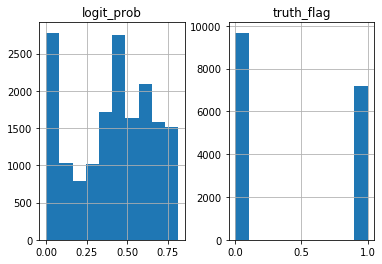

In [16]:
test_df[['truth_flag', 'logit_prob']].hist()

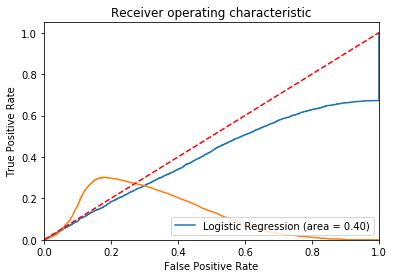

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc)
plt.plot(thresholds, csi)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
logisticRegr = LogisticRegressionCV(fit_intercept=True, penalty='l1', solver='liblinear', cv=5, n_jobs=4)
#logisticRegr = svm.SVC(probability=True)

df_balanced[['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'solarzenang']].head()

In [ ]:
df_balanced.head()

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
logisticRegr.fit(df_balanced[predict_features], df_balanced['truth_flag'])

In [ ]:
for coeff, feature in zip(logisticRegr.coef_[0], predict_features):
    print (coeff, feature)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
y_prob = logisticRegr.predict_proba(df_balanced[predict_features])[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true = df_balanced['truth_flag'], y_score = y_prob)
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)

In [ ]:
df_balanced['logit_proba'] = y_prob
df_balanced['sza_prob'] = 1
df_balanced.loc[df_balanced['solarzenang'] < 20, 'sza_prob'] = 0

In [ ]:
roc = roc_auc_score(y_true = df_balanced['truth_flag'], y_score = y_prob)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc)
plt.plot(thresholds, csi)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11,6))
ax = plt.axes()
plt.style.use('seaborn-whitegrid')
ax.scatter(df_balanced['logit_proba'], df_balanced['truth_flag'], marker='x');
ax.legend()

In [ ]:
final_gdf['sza_prob'] = 1
final_gdf.loc[final_gdf['solarzenang'] < 20, 'sza_prob'] = 0

In [ ]:
final_gdf['logit_prob'] = logisticRegr.predict_proba(final_gdf[predict_features])[:, 1]

In [ ]:
hs_gdf['logit_prob'] = logisticRegr.predict_proba(hs_gdf[predict_features])[:, 1]

In [ ]:
from sklearn.calibration import calibration_curve

In [ ]:
prob_true, prob_pred = calibration_curve(final_gdf['truth_flag'], final_gdf['logit_prob'], n_bins=10)

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = plt.axes()
plt.style.use('seaborn-whitegrid')
ax.plot(prob_pred, prob_true, marker='x');
ax.plot([0, 1], [0, 1], marker='x');
ax.legend()